# Regresión II: No entiendo lo que dicen

Debido a la contingencia ocasionada por el COVID, las teleconferencias son ahora mucho más comunes. Sin embargo, muchas veces el ruido de fondo no permite enender que es lo que una persona ha dicho, lo que ocasiona demoras en las reuniones. Además, el ruido de fondo (tráfico, perros, otras personas hablando, lluvia, etc..) puede ser un distractor importante en las reuniones. El profesor Alexander esta un poco cansado con esta situación, ya qu elas reuniones se alargan más de lo debido, y esto le quita tiempo para realizar otras actividades. Como los estudiantes de Machine LEarning ya saben utilizar redes neuronales, el profesor Alexander quiere que sus estudiantes desarrollen un sistema de mejora del audio, la idea es que los estudiantes desarrollen un modelo utilizando redes neuronales, que sea capaz de reducir el ruido de fondo de las señales de audio que se procesan. 

Para la realización de este proyecto el estudiante debera:

1. Crear una base de datos con señales de personas hablando, y de diferentes ruidos de fondo, los cuales deben ser mezclados para generar las señales de entrada en el modelo de regresión. Tenga en cuenta las sigueintes consideraciones:
    * Una red aprende con base en la información que le proporcionemos, asi que al crear la base de datos tenga en cuenta todas las posibilidades que se les ocurra de ruido de fondo y de señales de habla. Además la base de datos debe contener diferentes muestras de diferentes personas, invluyendo niños, niñas, mujeres y hombres. El objetivo es generalizar, no memorizar patrones, para esto debemos darle suficiente información a la red.
    * Una señal de voz puede tener entre 8000 y 40000 mmuestras por segundo de grabación. Esto es bastante para ser utilizado como entrada en la red. recuerde que entre mayor dimensionalidad en los datos de entrada, mayor será la complejidad de la red necesaria. Para disminuir la complejidad el profesor Alexander recomienda el uso de la densidad espectral de potencia (PSD) utilizando un número fijo de bins frecuenciales. La PSD representa la distribucion en frecuencia de la potencia de la señal.   
2. Definir las arquitecturas de red que debe probar.
3. Escoger la red que mejor se desempeñe.
4. Evaluar el rendimiento de la red.

Tenga en cuenta que todo el procedimiento debe ser lo mas amigable para probar. Es decir si el profesor Alexander quiere probar con una señal de voz que él produzca, entonces él solo deberia ingresar la señal de voz y el programa debería proporcionar a la salida una estimación de la señal de voz mejorada, con el ruido de fondo reducido.

Además el profesor quiere que contesten las siguientes preguntas:

1. ¿Qué puede concluir del comportamiento de la red y los datos proporcionados?
2. ¿Qué criterio utilizó para seleccionar la arquitectura de la red?
3. ¿Tiene la red el comportamiento esperado?, si no es así, ¿A qué cree que se debe esto?
4. ¿Qué le mejoraria al modelo que usted diseño?, ¿Cómo implementaría esas mejoras?

## Qué se debe entregar:

Par ala entrega del proyecto deben porporcionar:

1. La base de datos generada.
2. Un notebook de Jupyter donde presentan todo el pipeline para el entrenamiento de la red. Cada parte debe ser explicada.
3. El notebook debe incluir una función que permita ingresar una muestra de entrada y se proporcione la salida, sin mas pasos intermedios. Por lo tanto en esta función se debe tener en cuenta el acondicionamiento de los datos, antes de ser introducidos en la red neuronal par arealizar las predicciones.
4. El notebook debe incluir las respuestas a las preguntas planteadas.

# Ajuste de los datos

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as waves
import scipy.fftpack as fourier
import random
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import sounddevice as sd
import wavio
import soundfile as sf

def signal(data, frequency):
    # funcion que divide los puntos de una señal
    
    data = data[:,0]
    fixed_data = data[len(data)-frequency*2:]
    matrix = np.zeros(shape=(9600, 10))
    count = 0
    for i in range(10):
        for j in range(9600):
            matrix[j,i] = fixed_data[count]
            count += 1
    return np.transpose(matrix)

def words(word_list):
    # funcion que convierte todas las palabras en matrices 10*9600
    
    signals = []
    for word in word_list:
        for i in range(5):
            string = 'Palabras/{palabra}{index}.wav'.format(palabra = word, index = i + 1)
            frequency, data = waves.read(string)
            signals.append(signal(data, frequency))
    return signals

def noise(noise_list):
    # funcion que convierte todos los rudios en matrices 10*9600
    
    signals = []
    for noise in noise_list:
        string = 'Ruidos/{ruido}.wav'.format(ruido = noise)
        frequency, data = waves.read(string)
        signals.append(signal(data, frequency))
    return signals

def fourier256(piece):
    # funcion que aplica una transformada de fourier de 256 puntos
    
    new_piece = fourier.fft(piece, 256)    
    real_part = np.zeros(shape=(256,))
    imaginary_part = np.zeros(shape=(256,))
    for i in range(len(new_piece)):
        real_part[i] = new_piece[i].real
        imaginary_part[i] = new_piece[i].imag
    return real_part, imaginary_part

def fourierMatrix(word):
    # funcion que aplica una transformada de fourier a cada fila de una matriz
    
    real_part, imaginary_part = fourier256(word[0,:])
    for i in range(1,10):
        temp = fourier256(word[i,:])
        real_part = np.row_stack([real_part, temp[0]])
        imaginary_part = np.row_stack([imaginary_part, temp[1]])
    matrix = np.hstack([real_part, imaginary_part])
    return matrix

def inverseFourier(word):
    # funcion que aplica la inversa de una transformada de fourier a cada fila de una matriz
    
    complexMatrix = np.zeros(shape=(10, 256), dtype=complex)
    for i in range(10):
        for k in range(256):
            z = complex(word[i,k], word[i,k + 256])
            complexMatrix[i,k] = z
            
    matrix = np.zeros(shape=(10,9600))    
    for u in range(10):
        temp = fourier.ifft(complexMatrix[u,:],9600)
        for v in range(9600):
            matrix[u,v] = temp[v].real

    matrix = np.reshape(matrix, 96000)
    return matrix

def clean(sonido):
    string = 'Palabras/{palabra}.wav'.format(palabra = sonido)
    frequency, data = waves.read(string)
    matrix = signal(data, frequency)
    matrix = fourierMatrix(matrix)
    return matrix

# Implementación de la red neuronal

In [105]:
def data_split():
    # muestras de palabras y ruidos
    word_list = ['aguacate', 'biblioteca', 'cuaderno', 'escuela', 'guarderia', 'momento', 'parqueadero', 'trabajar', 'transmilenio', 'tristeza']
    noise_list = ['aguacero', 'licuadora', 'niños', 'trafico']

    # matrices de palabras y ruidos (10 x 9600)
    word_matrix_list = words(word_list)
    noise_matrix_list = noise(noise_list)

    # matrices de palabras y ruidos (10 x 512)
    fft_words = []
    for i in range(len(word_matrix_list)):
        fft_words.append(fourierMatrix(word_matrix_list[i]))

    fft_noises = []
    for i in range(len(noise_matrix_list)):
        fft_noises.append(fourierMatrix(noise_matrix_list[i]))

    # combinaciones lineales entre palabras y ruidos (10 x 512)   
    final = []    
    for i in range(50):
        num = random.uniform(0,1)
        final.append(num*fft_noises[i%4] + (1 - num)*fft_words[i])
    
    # datos de entrenamiento, prueba y validacion
    finalMatrix = final[0]
    for i in range(1,50):
        finalTemp = final[i]
        finalMatrix = np.vstack((finalMatrix, finalTemp))

    fft_words_matrix = fft_words[0]                            
    for i in range(1,50):
        fft_words_matrix = np.vstack((fft_words_matrix, fft_words[i]))

    finalMatrix = normalize(finalMatrix)
    fft_words_matrix = normalize(fft_words_matrix)

    X_temp, X_test, y_temp, y_test = train_test_split(finalMatrix, fft_words_matrix, test_size=0.3)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2)
    
    return [X_train, y_train, X_val, y_val, X_test, y_test]

def neural_network(X_train, y_train, X_val, y_val, X_test, y_test):
    # construimos la red 
    network = models.Sequential()
    network.add(layers.Dense(256, activation='sigmoid', input_shape=(512,)))
    network.add(layers.Dense(128, activation='sigmoid'))
    network.add(layers.Dense(256, activation='sigmoid'))
    network.add(layers.Dense(512))
    network.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return network

# Comportamiento y resultados

In [106]:
[X_train, y_train, X_val, y_val, X_test, y_test] = data_split()
network = neural_network(X_train, y_train, X_val, y_val, X_test, y_test)
hist = network.fit(X_train, y_train, epochs=200, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/200
3/3 [==============================] - 1s 87ms/step - loss: 0.1219 - mae: 0.2672 - val_loss: 0.0052 - val_mae: 0.0378
Epoch 2/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0044 - mae: 0.0322 - val_loss: 0.0023 - val_mae: 0.0187
Epoch 3/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0022 - mae: 0.0173 - val_loss: 0.0022 - val_mae: 0.0184
Epoch 4/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0022 - mae: 0.0180 - val_loss: 0.0025 - val_mae: 0.0245
Epoch 5/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0026 - mae: 0.0258 - val_loss: 0.0045 - val_mae: 0.0452
Epoch 6/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0048 - mae: 0.0485 - val_loss: 0.0065 - val_mae: 0.0632
Epoch 7/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0063 - mae: 0.0624 - val_loss: 0.0053 - val_mae: 0.0547
Epoch 8/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0050 - mae: 0.05

3/3 [==============================] - 0s 24ms/step - loss: 0.0022 - mae: 0.0210 - val_loss: 0.0022 - val_mae: 0.0219
Epoch 64/200
3/3 [==============================] - 0s 27ms/step - loss: 0.0022 - mae: 0.0211 - val_loss: 0.0022 - val_mae: 0.0220
Epoch 65/200
3/3 [==============================] - 0s 25ms/step - loss: 0.0022 - mae: 0.0212 - val_loss: 0.0022 - val_mae: 0.0219
Epoch 66/200
3/3 [==============================] - 0s 25ms/step - loss: 0.0022 - mae: 0.0210 - val_loss: 0.0022 - val_mae: 0.0222
Epoch 67/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0022 - mae: 0.0214 - val_loss: 0.0022 - val_mae: 0.0207
Epoch 68/200
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - mae: 0.0198 - val_loss: 0.0022 - val_mae: 0.0201
Epoch 69/200
3/3 [==============================] - 0s 25ms/step - loss: 0.0021 - mae: 0.0194 - val_loss: 0.0021 - val_mae: 0.0199
Epoch 70/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0021 - mae: 0.0190 - 

3/3 [==============================] - 0s 24ms/step - loss: 0.0020 - mae: 0.0129 - val_loss: 0.0020 - val_mae: 0.0140
Epoch 126/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0020 - mae: 0.0129 - val_loss: 0.0020 - val_mae: 0.0138
Epoch 127/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0020 - mae: 0.0126 - val_loss: 0.0020 - val_mae: 0.0138
Epoch 128/200
3/3 [==============================] - 0s 25ms/step - loss: 0.0020 - mae: 0.0128 - val_loss: 0.0020 - val_mae: 0.0139
Epoch 129/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0020 - mae: 0.0127 - val_loss: 0.0020 - val_mae: 0.0137
Epoch 130/200
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - mae: 0.0127 - val_loss: 0.0020 - val_mae: 0.0137
Epoch 131/200
3/3 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.012 - 0s 22ms/step - loss: 0.0020 - mae: 0.0125 - val_loss: 0.0020 - val_mae: 0.0138
Epoch 132/200
3/3 [==============================] -

Epoch 187/200
3/3 [==============================] - 0s 25ms/step - loss: 0.0020 - mae: 0.0123 - val_loss: 0.0020 - val_mae: 0.0135
Epoch 188/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0020 - mae: 0.0123 - val_loss: 0.0020 - val_mae: 0.0134
Epoch 189/200
3/3 [==============================] - 0s 25ms/step - loss: 0.0020 - mae: 0.0122 - val_loss: 0.0020 - val_mae: 0.0134
Epoch 190/200
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - mae: 0.0123 - val_loss: 0.0020 - val_mae: 0.0134
Epoch 191/200
3/3 [==============================] - 0s 27ms/step - loss: 0.0020 - mae: 0.0123 - val_loss: 0.0020 - val_mae: 0.0134
Epoch 192/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0020 - mae: 0.0123 - val_loss: 0.0020 - val_mae: 0.0134
Epoch 193/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0020 - mae: 0.0123 - val_loss: 0.0020 - val_mae: 0.0135
Epoch 194/200
3/3 [==============================] - 0s 23ms/step - loss: 0.

In [107]:
test_loss, test_mae = network.evaluate(X_test, y_test)
print('test_loss:', test_loss)
print('test_mae:', test_mae)
test_target_mav = abs(y_test).mean() # mean absolute value
print('test_target_mav:', test_target_mav)

5/5 [==============================] - 0s 2ms/step - loss: 0.0020 - mae: 0.0122
test_loss: 0.0019617334473878145
test_mae: 0.012249462306499481
test_target_mav: 0.01212560331293772


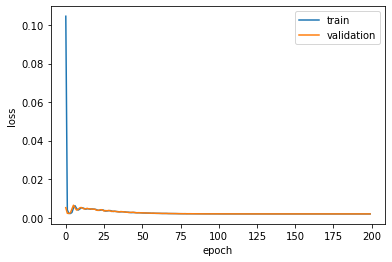

In [108]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [109]:
test_pred = network.predict(X_test)
maes = [] 
mean_mae = 0

for i in range(0,150,10):
    maes.append(abs(y_test[i:i + 10,:] - test_pred[i:i + 10,:]).mean())
    
for error in maes:
    mean_mae += error
    
mean_mae = mean_mae/len(maes)
print('test_pred_mae:', mean_mae)
print('test_target_mav:', test_target_mav)

test_pred_mae: 0.01224946312587248
test_target_mav: 0.01212560331293772


# Prueba

In [131]:
palabra = clean('aguacate2')
palabra_pred = network.predict(palabra)
palabra_pred = inverseFourier(palabra_pred)

wavio.write("myfile.wav", palabra_pred, 48000, sampwidth=2)
data, fs = sf.read('myfile.wav', dtype='float32') 
sd.play(data, fs)
status = sd.wait()  # Wait until file is done playin

[-0.42593384 -0.36743164 -0.3086853  ... -0.55792236 -0.5067749
 -0.45129395]
